Modified from `jko_test.ipynb`

In [1]:
from jax import config
config.update("jax_enable_x64", True)

from jax.scipy.special import kl_div

from jko_lab import *
import jax
from jax import numpy as jnp
from jax import lax
from sinkhorn import *

from animate import animate_hist_flow
import numpy as np
jax.config.update("jax_enable_x64", True)

In [3]:
n = 100
x = jnp.linspace(0.0, 1.0, n)
l = x[1] - x[0] 


X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2
finfo = jnp.finfo(jnp.result_type(C))

tiny = finfo.tiny / 0.9
# print(jnp.finfo(jnp.result_type(C)))

def V(x, l):
    # zero potential (heat eqn)
    return jnp.zeros_like(x)


    
    # double-well
    # return 100 * (x - 0.3)**2 * (x - 0.7)**2
    
    # harmonic
    # return 50 * (x - 0.5)**2

v_vals = V(x,l)  

def entropy(r):
    r = jnp.clip(r, tiny, None)
    return -jnp.sum(r * jnp.log(r))


r0 = 0.7 * jax.scipy.stats.norm.pdf(x, 0.25, 0.03) + 0.3 * jax.scipy.stats.norm.pdf(x, 0.75, 0.04)
# r0 = jnp.clip(r0, 1e-12, None)
r0 = r0 / (r0.sum() * l)  # normalize
r0 = jnp.clip(r0, tiny, None)

tau_max = 1e-1
tau_min = 1e-2
eps_max = 1e-3
eps_min=1e-4


p = X.shape[0]
# b0 = jnp.ones(p)

b = jnp.ones_like(x) / (n * l) 
rs = sinkhorn_flow_log(r0, C, X, v_vals, l, b, tau_max, tau_min, reg_max=eps_max, reg_min=eps_min, steps=1000, min_by=500,iters=500, alpha=1,m=2)


 

b = jnp.ones_like(x) / (n * l) 
dists = jnp.linalg.norm(rs - b[None, :], axis=1)
# kls = kl_div(rs, b[None, :])

kls = jnp.sum(kl_div(rs, b[None, :]), axis=1) * l 
Hs = jnp.array([entropy(r) for r in rs])

print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
for k in [0, 1, 5, 10, 20, 50, 100, 200, 500, 999, 1999, 2999, 3999, 4999, 5999, 6999, 7999, 8999, 9999]:
    if k < len(Hs):
        print(f" k={k:2d}: H={float(Hs[k]):.6f}, ||rho-b||={float(dists[k]):.6e}, KL={float(kls[k]):.6e}")

[Flow-Entropy] Entropy should increase, distance to uniform should decrease:
 k= 0: H=-137.654594, ||rho-b||=2.051765e+01, KL=1.400501e+00
 k= 1: H=-232.454784, ||rho-b||=3.516010e+01, KL=2.358078e+00
 k= 5: H=3.129726, ||rho-b||=9.789731e+00, KL=9.570345e-01
 k=10: H=3.120305, ||rho-b||=9.789762e+00, KL=9.571296e-01
 k=20: H=3.101668, ||rho-b||=9.789824e+00, KL=9.573179e-01
 k=50: H=3.427618, ||rho-b||=9.788731e+00, KL=9.540254e-01
 k=100: H=4.339051, ||rho-b||=9.787087e+00, KL=9.448190e-01
 k=200: H=4.481893, ||rho-b||=9.786938e+00, KL=9.433762e-01
 k=500: H=4.354185, ||rho-b||=9.787494e+00, KL=9.446662e-01
 k=999: H=0.000000, ||rho-b||=9.900000e+00, KL=1.000000e+00


In [5]:
n = 100
x = jnp.linspace(0.0, 1.0, n)
l = x[1] - x[0] 


X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2
finfo = jnp.finfo(jnp.result_type(C))

tiny = finfo.tiny / 0.9
# print(jnp.finfo(jnp.result_type(C)))

def V(x, l):
    # zero potential (heat eqn)
    return jnp.zeros_like(x)

    # return -jnp.log(x)*l


    
    # double-well
    # return 100 * (x - 0.3)**2 * (x - 0.7)**2
    
    # harmonic
    # return 50 * (x - 0.5)**2

v_vals = V(x,l)  

def entropy(r):
    r = jnp.clip(r, tiny, None)
    return -jnp.sum(r * jnp.log(r))


r0 = 0.7 * jax.scipy.stats.norm.pdf(x, 0.25, 0.03) + 0.3 * jax.scipy.stats.norm.pdf(x, 0.75, 0.04)
# r0 = jnp.clip(r0, 1e-12, None)
r0 = r0 / (r0.sum() * l)  # normalize
r0 = jnp.clip(r0, tiny, None)

tau_max = 1e-1
tau_min = 1e-2
eps_max = 1e-3
eps_min=1e-4

tiny = jnp.finfo(jnp.result_type(x)).tiny



p = X.shape[0]
# b0 = jnp.ones(p)
b = jax.nn.softmax(-((x-0.6)**2)/0.02)
b = jnp.clip(b, tiny, jnp.inf)
b = b / jnp.sum(b)


b = b / (b.sum() * l)
b = jnp.clip(b, tiny, jnp.inf)
v_vals = -jnp.log(b) * l
v_vals = v_vals - jnp.mean(v_vals)

rs = sinkhorn_flow_log(r0, C, X, v_vals, l, b, tau_max, tau_min, reg_max=eps_max, reg_min=eps_min, steps=10000, min_by=5000,iters=500, alpha=0.9)


 
dists = jnp.linalg.norm(rs - b[None, :], axis=1)
# kls = kl_div(rs, b[None, :])

kls = jnp.sum(kl_div(rs, b[None, :]), axis=1) * l 
Hs = jnp.array([entropy(r) for r in rs])

print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
for k in [0, 1, 5, 10, 20, 50, 100, 200, 500, 999, 1999, 2999, 3999, 4999, 5999, 6999, 7999, 8999, 9999]:
    if k < len(Hs):
        print(f" k={k:2d}: H={float(Hs[k]):.6f}, ||rho-b||={float(dists[k]):.6e}, KL={float(kls[k]):.6e}")

[Flow-Entropy] Entropy should increase, distance to uniform should decrease:
 k= 0: H=-137.654594, ||rho-b||=2.670070e+01, KL=4.687279e+00
 k= 1: H=-82.707672, ||rho-b||=2.183010e-01, KL=4.816888e-02
 k= 5: H=-82.896279, ||rho-b||=2.085350e-01, KL=4.544081e-02
 k=10: H=-82.893607, ||rho-b||=2.086725e-01, KL=4.548169e-02
 k=20: H=-82.887829, ||rho-b||=2.089701e-01, KL=4.557010e-02
 k=50: H=-82.867686, ||rho-b||=2.100095e-01, KL=4.587857e-02
 k=100: H=-82.830287, ||rho-b||=2.119482e-01, KL=4.645271e-02
 k=200: H=-82.787020, ||rho-b||=2.142110e-01, KL=4.712470e-02
 k=500: H=-82.981712, ||rho-b||=2.041754e-01, KL=4.414395e-02
 k=999: H=-82.944775, ||rho-b||=2.061037e-01, KL=4.474217e-02
 k=1999: H=-83.167854, ||rho-b||=1.949180e-01, KL=4.138353e-02
 k=2999: H=-83.144127, ||rho-b||=1.961963e-01, KL=4.183935e-02
 k=3999: H=-83.641356, ||rho-b||=1.726578e-01, KL=3.448668e-02
 k=4999: H=-82.771301, ||rho-b||=2.164433e-01, KL=4.863479e-02
 k=5999: H=-82.129502, ||rho-b||=2.517006e-01, KL=5.6850

In [20]:
print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
for k in [0, 1, 5, 10, 20, 50, 100, 200, 500, 999, 1999, 2999, 3999, 4999, 5999, 6999, 7999, 8999, 9999]:
    if k < len(Hs):
        print(f" k={k:2d}: H={float(Hs[k]):.6f}, ||rho-b||={float(dists[k]):.6f}, KL={float(kls[k]):.6f}")

[Flow-Entropy] Entropy should increase, distance to uniform should decrease:
 k= 0: H=-137.654594, ||rho-b||=26.700700, KL=4.687279
 k= 1: H=-86.144666, ||rho-b||=0.199047, KL=0.000191
 k= 5: H=-86.152166, ||rho-b||=0.197954, KL=0.000189
 k=10: H=-86.161021, ||rho-b||=0.196662, KL=0.000187
 k=20: H=-86.177111, ||rho-b||=0.194316, KL=0.000182
 k=50: H=-86.214439, ||rho-b||=0.188870, KL=0.000172
 k=100: H=-86.251158, ||rho-b||=0.183507, KL=0.000163
 k=200: H=-86.278909, ||rho-b||=0.179442, KL=0.000155
 k=500: H=-86.288106, ||rho-b||=0.178077, KL=0.000153
 k=999: H=-86.288106, ||rho-b||=0.178077, KL=0.000153


In [22]:
html = animate_hist_flow(
    mu_list=rs, x=np.asarray(x),
    target=b,                # or None
    interval=150,
    title="JKO Flow (entropy)"
)

Animation size has reached 20979407 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


In [17]:
n = 100
x = jnp.linspace(0.0, 1.0, n)
l = x[1] - x[0] 


X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2
finfo = jnp.finfo(jnp.result_type(C))

tiny = finfo.tiny / 0.9
# print(jnp.finfo(jnp.result_type(C)))

def V(x, l):
    # zero potential (heat eqn)
    return jnp.zeros_like(x)


    
    # double-well
    # return 100 * (x - 0.3)**2 * (x - 0.7)**2
    
    # harmonic
    # return 50 * (x - 0.5)**2

v_vals = V(x,l)  

def entropy(r):
    r = jnp.clip(r, tiny, None)
    return -jnp.sum(r * jnp.log(r))


r0 = 0.7 * jax.scipy.stats.norm.pdf(x, 0.25, 0.03) + 0.3 * jax.scipy.stats.norm.pdf(x, 0.75, 0.04)
# r0 = jnp.clip(r0, 1e-12, None)
r0 = r0 / (r0.sum() * l)  # normalize
r0 = jnp.clip(r0, tiny, None)

tau_max = 1e-1
tau_min = 1e-2
eps_max = 1e-3
eps_min=1e-4


b = jnp.ones_like(x) / (n * l) 
v_vals = jnp.zeros_like(x) 
rs = sinkhorn_flow_log(r0, C, X, v_vals, l, tau_max, tau_min, reg_max=eps_max, reg_min=eps_min, steps=10000, min_by=2500,iters=500, alpha=1, base_m=b)


dists = jnp.linalg.norm(rs - b[None, :], axis=1)
# kls = kl_div(rs, b[None, :])

kls = jnp.sum(kl_div(rs, b[None, :]), axis=1) * l 
Hs = jnp.array([entropy(r) for r in rs])

print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
for k in [0, 1, 5, 10, 20, 50, 100, 200, 500, 999, 1999, 2999, 3999, 4999, 5999, 6999, 7999, 8999, 9999]:
    if k < len(Hs):
        print(f" k={k:2d}: H={float(Hs[k]):.6f}, ||rho-b||={float(dists[k]):.6e}, KL={float(kls[k]):.6e}")

[Flow-Entropy] Entropy should increase, distance to uniform should decrease:
 k= 0: H=-137.654594, ||rho-b||=2.051765e+01, KL=1.400501e+00
 k= 1: H=0.989073, ||rho-b||=1.081743e-01, KL=5.969980e-05
 k= 5: H=0.994980, ||rho-b||=2.673898e-03, KL=3.649280e-08
 k=10: H=0.994980, ||rho-b||=2.670492e-03, KL=3.639988e-08
 k=20: H=0.994980, ||rho-b||=2.663685e-03, KL=3.621455e-08
 k=50: H=0.994980, ||rho-b||=2.643309e-03, KL=3.566260e-08
 k=100: H=0.994980, ||rho-b||=2.609493e-03, KL=3.475591e-08
 k=200: H=0.994980, ||rho-b||=2.542379e-03, KL=3.299099e-08
 k=500: H=0.994980, ||rho-b||=2.344629e-03, KL=2.805804e-08
 k=999: H=0.994981, ||rho-b||=2.023261e-03, KL=2.089283e-08
 k=1999: H=0.994982, ||rho-b||=1.359476e-03, KL=9.431444e-09
 k=2999: H=0.994983, ||rho-b||=5.873194e-04, KL=1.759975e-09
 k=3999: H=0.994983, ||rho-b||=5.897422e-05, KL=1.774311e-11
 k=4999: H=0.994983, ||rho-b||=1.329063e-07, KL=8.747212e-17
 k=5999: H=0.994983, ||rho-b||=9.957973e-09, KL=0.000000e+00
 k=6999: H=0.994983, 

In [18]:
n = 100
x = jnp.linspace(0.0, 1.0, n)
l = x[1] - x[0] 


X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2
finfo = jnp.finfo(jnp.result_type(C))

tiny = finfo.tiny / 0.9
# print(jnp.finfo(jnp.result_type(C)))

def V(x, l):
    # zero potential (heat eqn)
    #return jnp.zeros_like(x)
    x = jnp.clip(x,tiny,None)

    return -jnp.log(x)*l
    
    # double-well
    # return 100 * (x - 0.3)**2 * (x - 0.7)**2
    
    # harmonic
    # return 50 * (x - 0.5)**2

v_vals = V(x,l)  

def entropy(r):
    r = jnp.clip(r, tiny, None)
    return -jnp.sum(r * jnp.log(r))


r0 = 0.7 * jax.scipy.stats.norm.pdf(x, 0.25, 0.03) + 0.3 * jax.scipy.stats.norm.pdf(x, 0.75, 0.04)
# r0 = jnp.clip(r0, 1e-12, None)
r0 = r0 / (r0.sum() * l)  # normalize
r0 = jnp.clip(r0, tiny, None)

tau_max = 1e1
tau_min = 1e-4
eps_max = 1e-0
eps_min=1e-5


p = X.shape[0]
# b0 = jnp.ones(p)

b = jax.nn.softmax(-((x-0.6)**2)/0.02)
# b = b / jnp.sum(b)
b = jnp.clip(b, tiny, None)
b = b / (b.sum() * l)
b = jnp.clip(b, tiny, None)



# v_vals = jnp.zeros_like(x)     # we steer via the base measure now

rs = sinkhorn_flow_log(
    r0, C, X, v_vals, l, tau_max, tau_min,
    reg_max=eps_max, reg_min=eps_min,
    steps=10000, min_by=5000, iters=1000, alpha=1,
    base_m=b                                  # <<< THIS is the only “new” input
)
dists = jnp.linalg.norm(rs - b[None, :], axis=1)
# kls = kl_div(rs, b[None, :])

kls = jnp.sum(kl_div(rs, b[None, :]), axis=1) * l 
Hs = jnp.array([entropy(r) for r in rs])

print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
for k in [0, 1, 5, 10, 20, 50, 100, 200, 500, 999, 1999, 2999, 3999, 4999, 5999, 6999, 7999, 8999, 9999]:
    if k < len(Hs):
        print(f" k={k:2d}: H={float(Hs[k]):.6f}, ||rho-b||={float(dists[k]):.6e}, KL={float(kls[k]):.6e}")

[Flow-Entropy] Entropy should increase, distance to uniform should decrease:
 k= 0: H=-137.654594, ||rho-b||=2.670070e+01, KL=4.687279e+00
 k= 1: H=-85.164775, ||rho-b||=3.422456e-01, KL=5.718276e-04
 k= 5: H=-85.165211, ||rho-b||=3.421825e-01, KL=5.716134e-04
 k=10: H=-85.165761, ||rho-b||=3.421028e-01, KL=5.713431e-04
 k=20: H=-85.166880, ||rho-b||=3.419406e-01, KL=5.707938e-04
 k=50: H=-85.170387, ||rho-b||=3.414324e-01, KL=5.690733e-04
 k=100: H=-85.176769, ||rho-b||=3.405076e-01, KL=5.659496e-04
 k=200: H=-85.191807, ||rho-b||=3.383285e-01, KL=5.586236e-04
 k=500: H=-85.261488, ||rho-b||=3.282298e-01, KL=5.253124e-04
 k=999: H=-85.507553, ||rho-b||=2.925535e-01, KL=4.160091e-04
 k=1999: H=-86.159415, ||rho-b||=1.980292e-01, KL=1.887785e-04
 k=2999: H=-86.289026, ||rho-b||=1.792123e-01, KL=1.543097e-04
 k=3999: H=-86.302121, ||rho-b||=1.772937e-01, KL=1.510241e-04
 k=4999: H=-86.303531, ||rho-b||=1.770815e-01, KL=1.506728e-04
 k=5999: H=-86.303532, ||rho-b||=1.770815e-01, KL=1.5067

In [5]:
def kl_div(p, q):
    finfo = jnp.finfo(jnp.result_type(p))
    tiny = finfo.tiny / 0.9
    p = jnp.clip(p, tiny, None)
    q = jnp.clip(q, tiny, None)
    return p * (jnp.log(p) - jnp.log(q))

def entropy(r):
    finfo = jnp.finfo(jnp.result_type(r))
    tiny = finfo.tiny / 0.9
    r = jnp.clip(r, tiny, None)
    return -jnp.sum(r * jnp.log(r))

# Grid
n = 100
x = jnp.linspace(0.0, 1.0, n)
l = x[1] - x[0]
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2
finfo = jnp.finfo(jnp.result_type(C))
tiny = finfo.tiny / 0.9

# NO POTENTIAL - just flow to target
v_vals = jnp.zeros_like(x)

# Initial: bimodal at 0.25 and 0.75
r0 = 0.7 * jax.scipy.stats.norm.pdf(x, 0.25, 0.03) + 0.3 * jax.scipy.stats.norm.pdf(x, 0.75, 0.04)
r0 = r0 / (r0.sum() * l)  # Normalize as density
r0 = jnp.clip(r0, tiny, None)

# Target: Gaussian at 0.6 (as DENSITY)
b_target_density = jax.nn.softmax(-((x-0.6)**2)/0.02)
b_target_density = b_target_density / (b_target_density.sum() * l)  # Normalize as density
b_target_density = jnp.clip(b_target_density, tiny, None)

# Convert density to MASS for the algorithm (this is the key fix)
b_target_mass = b_target_density * l  # ρ(x) * Δx = mass in each bin
b_target_mass = jnp.clip(b_target_mass, tiny, None)

print("Initial distribution:")
print(f"  Mass: {r0.sum() * l:.6f}")
print(f"  Entropy: {entropy(r0):.6f}")
print(f"  KL to target: {jnp.sum(kl_div(r0, b_target_density)) * l:.6e}")

print("\nTarget distribution:")
print(f"  Mass (should be 1.0): {b_target_density.sum() * l:.6f}")
print(f"  Mass version sum: {b_target_mass.sum():.6f}")
print(f"  Entropy: {entropy(b_target_density):.6f}")

# Run with base_m as MASS, not density
# rs = sinkhorn_flow_log(
#     r0, C, X, v_vals, l, 
#     tau_max=1e-1,
#     tau_min=1e-4,
#     reg_max=1e-2,
#     reg_min=1e-5,
#     steps=5000,
#     min_by=2500,
#     iters=1000,
#     alpha=0.3,
#     stop=0.0,
#     base_m=b_target_mass  # <<< Pass MASS, not density
# )

rs = sinkhorn_flow_log(
    r0, C, X, v_vals, l, 
    tau_max=1e-1,
    tau_min=1e-5,      # Go much smaller
    reg_max=1e-2,
    reg_min=1e-6,      # Go much smaller  
    steps=10000,       # Many more steps
    min_by=5000,       # Very slow annealing
    iters=2000,        # Many more inner iterations
    alpha=0.5,         # Moderate damping
    stop=0,         # Much tighter stopping
    base_m=b_target_mass
)
# Compare results with DENSITY (rs is already density)
dists = jnp.linalg.norm(rs - b_target_density[None, :], axis=1)
kls = jnp.sum(kl_div(rs, b_target_density[None, :]), axis=1) * l
Hs = jnp.array([entropy(r) for r in rs])

print("\n" + "="*70)
print("FLOW RESULTS")
print("="*70)
for k in [0, 1, 10, 50, 100, 500, 1000, 2000, 3000, 4000, 4999]:
    if k < len(Hs):
        print(f" k={k:5d}: H={float(Hs[k]):10.6f}, ||rho-b||={float(dists[k]):.6e}, KL={float(kls[k]):.6e}")

print(f"\nFinal KL reduction: {kls[0] / (kls[-1] + 1e-12):.1f}x")
print(f"Final distance: {dists[-1]:.6e}")

Initial distribution:
  Mass: 1.000000
  Entropy: -137.654594
  KL to target: 4.687279e+00

Target distribution:
  Mass (should be 1.0): 1.000000
  Mass version sum: 1.000000
  Entropy: -87.505295

FLOW RESULTS
 k=    0: H=-137.654594, ||rho-b||=2.670070e+01, KL=4.687279e+00
 k=    1: H=-86.144666, ||rho-b||=1.990468e-01, KL=1.914218e-04
 k=   10: H=-86.146956, ||rho-b||=1.987130e-01, KL=1.907750e-04
 k=   50: H=-86.156723, ||rho-b||=1.972891e-01, KL=1.880286e-04
 k=  100: H=-86.168033, ||rho-b||=1.956400e-01, KL=1.848735e-04
 k=  500: H=-86.230233, ||rho-b||=1.865641e-01, KL=1.680029e-04
 k= 1000: H=-86.265115, ||rho-b||=1.814648e-01, KL=1.588979e-04
 k= 2000: H=-86.284528, ||rho-b||=1.786136e-01, KL=1.539410e-04
 k= 3000: H=-86.287722, ||rho-b||=1.781353e-01, KL=1.531325e-04
 k= 4000: H=-86.288108, ||rho-b||=1.780770e-01, KL=1.530351e-04
 k= 4999: H=-86.288108, ||rho-b||=1.780770e-01, KL=1.530351e-04

Final KL reduction: 30628.8x
Final distance: 1.780770e-01


In [3]:
# After the flow completes, check the final distribution
r_final = rs[-1]

print("\n" + "="*70)
print("FINAL STATE ANALYSIS")
print("="*70)

print(f"Final r sum: {r_final.sum() * l:.6f}")
print(f"Target b sum: {b_target_density.sum() * l:.6f}")

# Check if they have the same shape
print(f"\nShape comparison:")
print(f"  r peak location: x = {x[jnp.argmax(r_final)]:.3f}")
print(f"  b peak location: x = {x[jnp.argmax(b_target_density)]:.3f}")

# Check the ratio
ratio = r_final / b_target_density
print(f"\nRatio r_final / b_target:")
print(f"  Min/Max: {ratio.min():.3f} / {ratio.max():.3f}")
print(f"  Mean: {ratio.mean():.3f}")
print(f"  Std: {ratio.std():.3f}")

# Plot-like info: show the distributions at a few points
print(f"\nDistribution values at key locations:")
for xi in [0.3, 0.4, 0.5, 0.6, 0.7]:
    idx = jnp.argmin(jnp.abs(x - xi))
    print(f"  x={xi:.1f}: r_final={r_final[idx]:.6f}, target={b_target_density[idx]:.6f}, ratio={r_final[idx]/b_target_density[idx]:.3f}")

# Most importantly: what's the actual difference?
diff = r_final - b_target_density
print(f"\nDifference (r_final - target):")
print(f"  L1 norm: {jnp.sum(jnp.abs(diff)) * l:.6e}")
print(f"  L2 norm: {jnp.sqrt(jnp.sum(diff**2) * l):.6e}")
print(f"  Max abs: {jnp.max(jnp.abs(diff)):.6e}")


FINAL STATE ANALYSIS
Final r sum: 1.000000
Target b sum: 1.000000

Shape comparison:
  r peak location: x = 0.596
  b peak location: x = 0.596

Ratio r_final / b_target:
  Min/Max: 0.988 / 1.532
  Mean: 1.117
  Std: 0.139

Distribution values at key locations:
  x=0.3: r_final=0.053361, target=0.048515, ratio=1.100
  x=0.4: r_final=0.605411, target=0.584887, ratio=1.035
  x=0.5: r_final=2.300230, target=2.297661, ratio=1.001
  x=0.6: r_final=3.937458, target=3.986269, ratio=0.988
  x=0.7: r_final=2.490897, target=2.493072, ratio=0.999

Difference (r_final - target):
  L1 norm: 1.195040e-02
  L2 norm: 1.789741e-02
  Max abs: 4.881121e-02


In [28]:
# Add this diagnostic RIGHT AFTER defining b_target_mass
print("\n" + "="*70)
print("PROXIMAL OPERATOR TEST")
print("="*70)

# Test: what does prox return when given uniform input?
test_K_Ta = jnp.ones_like(x)
test_kappa = 1.0

# With uniform base_m (original behavior)
test_prox_uniform = prox_kl_g_log(test_K_Ta, v_vals, test_kappa, base_m=jnp.ones_like(x) * l)
print(f"Prox with UNIFORM base_m:")
print(f"  Min/Max: {test_prox_uniform.min():.6e} / {test_prox_uniform.max():.6e}")
print(f"  Ratio max/min: {test_prox_uniform.max() / test_prox_uniform.min():.3f}")

# With non-uniform base_m (your target)
test_prox_target = prox_kl_g_log(test_K_Ta, v_vals, test_kappa, base_m=b_target_mass)
print(f"\nProx with TARGET base_m:")
print(f"  Min/Max: {test_prox_target.min():.6e} / {test_prox_target.max():.6e}")
print(f"  Ratio max/min: {test_prox_target.max() / test_prox_target.min():.3f}")

# The prox output should be proportional to base_m when K_Ta is uniform
print(f"\nProx / base_m (should be constant if working correctly):")
ratio = test_prox_target / b_target_mass
print(f"  Min/Max: {ratio.min():.6e} / {ratio.max():.6e}")
print(f"  Std dev: {jnp.std(ratio):.6e}")

# Actually, let's check the formula more carefully
# prox = [K_Ta * exp(-kappa * v) * base_m^kappa]^(1/(1+kappa))
# With v=0, K_Ta=1, kappa=1: prox = [base_m^1]^(1/2) = base_m^0.5
expected = b_target_mass ** 0.5
print(f"\nExpected (base_m^0.5) vs Actual prox:")
print(f"  Match: {jnp.allclose(expected, test_prox_target)}")
print(f"  Max difference: {jnp.max(jnp.abs(expected - test_prox_target)):.6e}")


PROXIMAL OPERATOR TEST
Prox with UNIFORM base_m:
  Min/Max: 1.005038e-01 / 1.005038e-01
  Ratio max/min: 1.000

Prox with TARGET base_m:
  Min/Max: 2.477380e-05 / 2.006623e-01
  Ratio max/min: 8099.778

Prox / base_m (should be constant if working correctly):
  Min/Max: 4.983498e+00 / 4.036523e+04
  Std dev: 5.825270e+03

Expected (base_m^0.5) vs Actual prox:
  Match: True
  Max difference: 0.000000e+00


In [5]:
html = animate_hist_flow(
    mu_list=rs, x=np.asarray(x),
    target=b,                # or None
    interval=150,
    title="JKO Flow (entropy)"
)

Animation size has reached 20976282 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


In [23]:
tau_max = 1e-1
tau_min = 1e-3
eps_max = 1e-2
eps_min=1e-4


rs = sinkhorn_flow_log(r0, C, X, v_vals, l, tau_max, tau_min, reg_max=eps_max, reg_min=eps_min, steps=10000, min_by=2500,iters=500, alpha=1)
dists = jnp.linalg.norm(rs - b[None, :], axis=1)
kls = jnp.sum(kl_div(rs, b[None, :]), axis=1) * l 
Hs = jnp.array([entropy(r) for r in rs])

print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
for k in [0, 1, 5, 10, 20, 50, 100, 200, 500, 999, 1999, 2999, 3999, 4999, 5999, 6999, 7999, 8999, 9999]:
    if k < len(Hs):
        print(f" k={k:2d}: H={float(Hs[k]):.6f}, ||rho-b||={float(dists[k]):.6e}, KL={float(kls[k]):.6e}")

[Flow-Entropy] Entropy should increase, distance to uniform should decrease:
 k= 0: H=-137.654594, ||rho-b||=2.051765e+01, KL=1.400501e+00
 k= 1: H=0.993938, ||rho-b||=4.538214e-02, KL=1.055474e-05
 k= 5: H=0.993942, ||rho-b||=4.530843e-02, KL=1.052051e-05
 k=10: H=0.993946, ||rho-b||=4.521639e-02, KL=1.047786e-05
 k=20: H=0.993954, ||rho-b||=4.503261e-02, KL=1.039294e-05
 k=50: H=0.993979, ||rho-b||=4.448378e-02, KL=1.014140e-05
 k=100: H=0.994020, ||rho-b||=4.357759e-02, KL=9.732798e-06
 k=200: H=0.994097, ||rho-b||=4.179835e-02, KL=8.954877e-06
 k=500: H=0.994298, ||rho-b||=3.673866e-02, KL=6.919185e-06
 k=999: H=0.994549, ||rho-b||=2.923609e-02, KL=4.382035e-06
 k=1999: H=0.994846, ||rho-b||=1.645162e-02, KL=1.385994e-06
 k=2999: H=0.994980, ||rho-b||=2.446297e-03, KL=3.054660e-08
 k=3999: H=0.994983, ||rho-b||=1.472149e-06, KL=1.105401e-14
 k=4999: H=0.994983, ||rho-b||=1.471491e-06, KL=1.104840e-14
 k=5999: H=0.994983, ||rho-b||=1.471491e-06, KL=1.104616e-14
 k=6999: H=0.994983, 

In [32]:
tau_max = 1e-1
tau_min = 1e-2
eps_max = 1e-3
eps_min=1e-4


rs = sinkhorn_flow_log(r0, C, X, v_vals, l, tau_max, tau_min, reg_max=eps_max, reg_min=eps_min, steps=10000, min_by=2500,iters=500, alpha=1)
dists = jnp.linalg.norm(rs - b[None, :], axis=1)
kls = jnp.sum(kl_div(rs, b[None, :]), axis=1) * l 
Hs = jnp.array([entropy(r) for r in rs])

print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
for k in [0, 1, 5, 10, 20, 50, 100, 200, 500, 999, 1999, 2999, 3999, 4999, 5999, 6999, 7999, 8999, 9999]:
    if k < len(Hs):
        print(f" k={k:2d}: H={float(Hs[k]):.6f}, ||rho-b||={float(dists[k]):.6e}, KL={float(kls[k]):.6e}")

[Flow-Entropy] Entropy should increase, distance to uniform should decrease:
 k= 0: H=-137.654594, ||rho-b||=2.051765e+01, KL=1.400501e+00
 k= 1: H=0.931914, ||rho-b||=3.533243e-01, KL=6.370608e-04
 k= 5: H=0.994983, ||rho-b||=1.921456e-04, KL=1.883478e-10
 k=10: H=0.994983, ||rho-b||=1.299209e-08, KL=0.000000e+00
 k=20: H=0.994983, ||rho-b||=7.141535e-09, KL=0.000000e+00
 k=50: H=0.994983, ||rho-b||=2.568554e-08, KL=0.000000e+00
 k=100: H=0.994983, ||rho-b||=1.187984e-08, KL=0.000000e+00
 k=200: H=0.994983, ||rho-b||=2.832365e-08, KL=0.000000e+00
 k=500: H=0.994983, ||rho-b||=1.840663e-07, KL=1.704585e-16
 k=999: H=0.994983, ||rho-b||=6.976737e-08, KL=0.000000e+00
 k=1999: H=0.994983, ||rho-b||=4.778709e-07, KL=1.166295e-15
 k=2999: H=0.994983, ||rho-b||=6.105177e-07, KL=1.892986e-15
 k=3999: H=0.994983, ||rho-b||=4.033663e-07, KL=8.343494e-16
 k=4999: H=0.994983, ||rho-b||=7.055328e-09, KL=0.000000e+00
 k=5999: H=0.994983, ||rho-b||=4.069919e-10, KL=0.000000e+00
 k=6999: H=0.994983, 

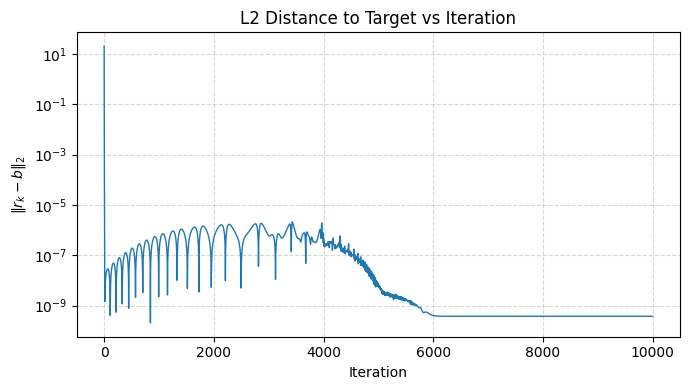

In [34]:
import matplotlib.pyplot as plt

iters = jnp.arange(len(dists))

plt.figure(figsize=(7,4))
plt.plot(iters, dists, lw=1)
plt.yscale('log')            # optional: if distance decays exponentially
plt.xlabel('Iteration')
plt.ylabel(r'$\|r_k - b\|_2$')
plt.title('L2 Distance to Target vs Iteration')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

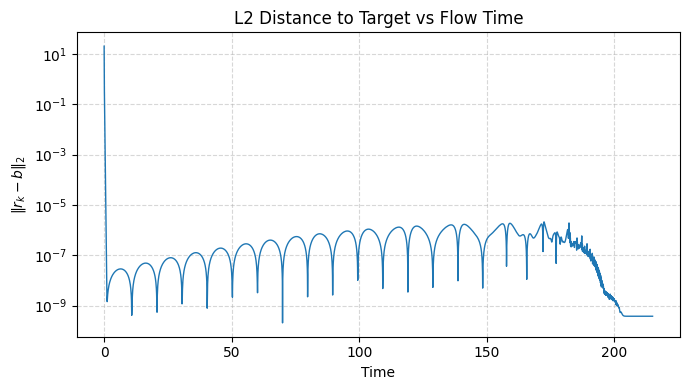

In [36]:
steps = 10000
min_by = 5000
div = max(1, min(min_by, steps - 1))
beta = jnp.log(tau_max / tau_min) / div
idx = jnp.arange(steps)
taus = tau_max * jnp.exp(-beta * idx)
t = jnp.concatenate([jnp.zeros(1), jnp.cumsum(taus)])  # "time" axis

# Plot on a log-scaled x-axis (time or iteration)
plt.figure(figsize=(7,4))
plt.plot(t, dists, lw=1)
                    # log scale on time/iteration
plt.yscale('log')                    # optional: also log y if magnitudes vary a lot
plt.xlabel('Time')
plt.ylabel(r'$\|r_k - b\|_2$')
plt.title('L2 Distance to Target vs Flow Time')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [30]:
min_by=5000
steps=10000

tau_max = 1e-1
tau_min = 1e-2

div = max(1, min(min_by, steps - 1))
beta  = jnp.log(tau_max / tau_min) / div
idx = jnp.arange(steps)
taus = tau_max * jnp.exp(-beta * idx)

sum(taus)

Array(215.02527234, dtype=float64, weak_type=True)

In [25]:
tau_max = 1e-1
tau_min = 1e-3
eps_max = 1e-3
eps_min=1e-5


rs = sinkhorn_flow_log(r0, C, X, v_vals, l, tau_max, tau_min, reg_max=eps_max, reg_min=eps_min, steps=10000, min_by=2500,iters=500, alpha=1)
dists = jnp.linalg.norm(rs - b[None, :], axis=1)
kls = jnp.sum(kl_div(rs, b[None, :]), axis=1) * l 
Hs = jnp.array([entropy(r) for r in rs])

print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
for k in [0, 1, 5, 10, 20, 50, 100, 200, 500, 999, 1999, 2999, 3999, 4999, 5999, 6999, 7999, 8999, 9999]:
    if k < len(Hs):
        print(f" k={k:2d}: H={float(Hs[k]):.6f}, ||rho-b||={float(dists[k]):.6e}, KL={float(kls[k]):.6e}")

[Flow-Entropy] Entropy should increase, distance to uniform should decrease:
 k= 0: H=-137.654594, ||rho-b||=2.051765e+01, KL=1.400501e+00
 k= 1: H=0.931914, ||rho-b||=3.533243e-01, KL=6.370608e-04
 k= 5: H=0.994983, ||rho-b||=2.197031e-04, KL=2.462476e-10
 k=10: H=0.994983, ||rho-b||=3.304197e-08, KL=0.000000e+00
 k=20: H=0.994983, ||rho-b||=4.031643e-08, KL=0.000000e+00
 k=50: H=0.994983, ||rho-b||=2.564557e-08, KL=0.000000e+00
 k=100: H=0.994983, ||rho-b||=5.931384e-08, KL=0.000000e+00
 k=200: H=0.994983, ||rho-b||=2.523531e-07, KL=3.319455e-16
 k=500: H=0.994983, ||rho-b||=1.379715e-07, KL=9.868649e-17
 k=999: H=0.994983, ||rho-b||=9.190386e-07, KL=4.305198e-15
 k=1999: H=0.994983, ||rho-b||=6.891370e-07, KL=2.415576e-15
 k=2999: H=0.994983, ||rho-b||=8.367581e-10, KL=0.000000e+00
 k=3999: H=0.994983, ||rho-b||=8.341260e-10, KL=0.000000e+00
 k=4999: H=0.994983, ||rho-b||=8.341875e-10, KL=0.000000e+00
 k=5999: H=0.994983, ||rho-b||=8.341290e-10, KL=0.000000e+00
 k=6999: H=0.994983, 

In [26]:
tau_max = 1e-0
tau_min = 1e-3
eps_max = 1e-1
eps_min=1e-4


rs = sinkhorn_flow_log(r0, C, X, v_vals, l, tau_max, tau_min, reg_max=eps_max, reg_min=eps_min, steps=10000, min_by=2500,iters=500, alpha=1)
dists = jnp.linalg.norm(rs - b[None, :], axis=1)
kls = jnp.sum(kl_div(rs, b[None, :]), axis=1) * l 
Hs = jnp.array([entropy(r) for r in rs])

print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
for k in [0, 1, 5, 10, 20, 50, 100, 200, 500, 999, 1999, 2999, 3999, 4999, 5999, 6999, 7999, 8999, 9999]:
    if k < len(Hs):
        print(f" k={k:2d}: H={float(Hs[k]):.6f}, ||rho-b||={float(dists[k]):.6e}, KL={float(kls[k]):.6e}")

[Flow-Entropy] Entropy should increase, distance to uniform should decrease:
 k= 0: H=-137.654594, ||rho-b||=2.051765e+01, KL=1.400501e+00
 k= 1: H=0.992606, ||rho-b||=6.851788e-02, KL=2.401114e-05
 k= 5: H=0.992612, ||rho-b||=6.843766e-02, KL=2.395531e-05
 k=10: H=0.992619, ||rho-b||=6.833574e-02, KL=2.388445e-05
 k=20: H=0.992633, ||rho-b||=6.812671e-02, KL=2.373943e-05
 k=50: H=0.992678, ||rho-b||=6.746356e-02, KL=2.328207e-05
 k=100: H=0.992759, ||rho-b||=6.626761e-02, KL=2.246796e-05
 k=200: H=0.992929, ||rho-b||=6.366766e-02, KL=2.074640e-05
 k=500: H=0.993448, ||rho-b||=5.503008e-02, KL=1.551095e-05
 k=999: H=0.994132, ||rho-b||=4.096046e-02, KL=8.599717e-06
 k=1999: H=0.994789, ||rho-b||=1.956466e-02, KL=1.961200e-06
 k=2999: H=0.994983, ||rho-b||=5.849082e-04, KL=1.745556e-09
 k=3999: H=0.994983, ||rho-b||=2.117676e-06, KL=2.288517e-14
 k=4999: H=0.994983, ||rho-b||=2.117676e-06, KL=2.288405e-14
 k=5999: H=0.994983, ||rho-b||=2.117676e-06, KL=2.288517e-14
 k=6999: H=0.994983, 

In [13]:
import numpy as np

# --- choose frame indices ---
idx = np.unique(np.concatenate([
    np.arange(0, 10),              # steps 0–9
    np.array([10, 20, 50, 100, 1000]),  # milestones
    np.arange(2000, len(rs), 1000)      # every 1000 after
])).astype(int)
idx = idx[idx < len(rs)]

# --- subset the flow and convert to numpy ---
rs_sub = np.asarray(rs[idx])
x_np   = np.asarray(x)

# --- optionally modify your animate_hist_flow to show custom labels ---
# If your function supports a title per frame, you can do:
titles = [f"frame {i}" for i in idx]

html = animate_hist_flow(
    mu_list=rs_sub,
    x=x_np,
    target=b,
    interval=5000,
    title="JKO Flow (selected steps)",
)

# display alongside step numbers
from IPython.display import display, HTML
display(HTML(f"<p>Frames correspond to steps: {idx.tolist()}</p>"))
html


In [ ]:
import numpy as np

# --- choose frame indices ---
idx = np.unique(np.concatenate([
    np.arange(0, 999),              # steps 0–9
])).astype(int)
idx = idx[idx < len(rs)]

# --- subset the flow and convert to numpy ---
rs_sub = np.asarray(rs[idx])
x_np   = np.asarray(x)

# --- optionally modify your animate_hist_flow to show custom labels ---
# If your function supports a title per frame, you can do:
titles = [f"frame {i}" for i in idx]

html = animate_hist_flow(
    mu_list=rs_sub,
    x=x_np,
    target=b,
    interval=5000,
    title="JKO Flow (selected steps)",
)

# display alongside step numbers
from IPython.display import display, HTML
display(HTML(f"<p>Frames correspond to steps: {idx.tolist()}</p>"))
html


In [20]:
from IPython.display import HTML

html = animate_hist_flow(
    mu_list=rs, x=np.asarray(x),
    target=b,                # or None
    interval=1000,
    title="JKO Flow (entropy)",
    return_html = False
)
html_str = html.to_jshtml()

with open("flow_eps_1e-2_tau_1e-1.html", "w") as f:
    f.write(html_str)
